참고 내용
- https://towardsdatascience.com/using-b-splines-and-k-means-to-cluster-time-series-16468f588ea6
- https://stackoverflow.com/questions/61807542/generate-a-b-spline-basis-in-scipy-like-bs-in-r
- https://www.youtube.com/watch?v=YvaBsb0T8Og


In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('read_csv').getOrCreate()
# spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [2]:
# csv 데이터 불러오기
t = spark.read.csv('./Sales_Transactions_Dataset_Weekly.csv', header=True, inferSchema=True)
t = t.select(['Product_Code']+t.columns[55:])
# normalized 열 vector변환
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=t.columns[1:], outputCol="norm_sales")
new_t = vecAssembler.transform(t)


In [85]:
# B-spline coefficent 계산을 위한 라이브러리 import
import numpy as np
from scipy.interpolate import BSpline
import pyspark.sql.functions as F
from pyspark.sql.types import *
import matplotlib.pyplot as plt
# B-Spline에 대한 UDF 생성
#@F.udf(returnType=)
def basis_bspline(cp_cnt, knots_cnt):
    x = np.linspace(0, 1, cp_cnt) # 데이터 기간과 같은 time 공간 생성
    these_knots = np.linspace(0,1,knots_cnt-2) # 나누고자 하는 knot의 갯수 만큼 생성
    numpyknots = np.concatenate(([0,0,0],these_knots,[1,1,1])) # python BSpline은 앞뒤로 3개씩 knots를 무시하므로 추가
    y_py = np.zeros((x.shape[0], knots_cnt))#len(these_knots)+2)) # B-Spline의 basis를 위한 numpy.array 생성(time공간 x knots갯수+2)
    for i in range(len(these_knots)+2):
        y_py[:,i] = BSpline(numpyknots, (np.arange(len(these_knots)+2)==i).astype(float), 3, extrapolate=False)(x) # time 특성에 따른 basis 생성 (time공간 x knots갯수+2)

    plt.plot(x,y_py) # B-Spline basis plot
    plt.title('In SciPy')

    return y_py

def cvt_bspline(basis):
    return F.udf(lambda row: np.dot(np.dot(np.linalg.inv(np.dot(basis.T,basis)),basis.T),np.array(np.array(row)).T).T.tolist(), ArrayType(FloatType()))


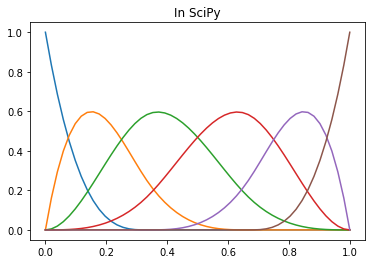

In [86]:
basis = basis_bspline(52,6)
new_t = new_t.withColumn('bs_sales', cvt_bspline(basis) (F.col('norm_sales')))

In [87]:
basis # B-Spline basis 행렬

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [8.33706493e-01, 1.61255852e-01, 5.00373160e-03, 3.39236040e-05,
        0.00000000e+00, 0.00000000e+00],
       [6.86952982e-01, 2.93507022e-01, 1.92686071e-02, 2.71388832e-04,
        0.00000000e+00, 0.00000000e+00],
       [5.58518217e-01, 3.98890698e-01, 4.16751476e-02, 9.15937309e-04,
        0.00000000e+00, 0.00000000e+00],
       [4.47180949e-01, 4.79544067e-01, 7.11038741e-02, 2.17111066e-03,
        0.00000000e+00, 0.00000000e+00],
       [3.51719927e-01, 5.37604315e-01, 1.06435308e-01, 4.24045051e-03,
        0.00000000e+00, 0.00000000e+00],
       [2.70913902e-01, 5.75208630e-01, 1.46549969e-01, 7.32749847e-03,
        0.00000000e+00, 0.00000000e+00],
       [2.03541624e-01, 5.94494199e-01, 1.90328380e-01, 1.16357962e-02,
        0.00000000e+00, 0.00000000e+00],
       [1.48381844e-01, 5.97598209e-01, 2.36651062e-01, 1.73688853e-02,
        0.00000000e+00, 

In [88]:
np.dot(np.linalg.inv(np.dot(basis.T,basis)),basis.T)

array([[ 0.46750951,  0.34246849,  0.23700226,  0.1496584 ,  0.07898447,
         0.02352807, -0.01816325, -0.04754189, -0.06606028, -0.07517086,
        -0.07632603, -0.07097823, -0.06057988, -0.04658341, -0.03044122,
        -0.01360576,  0.00247055,  0.0163353 ,  0.026835  ,  0.03401188,
         0.03820715,  0.03976198,  0.03901757,  0.03631509,  0.03199573,
         0.02640069,  0.01987114,  0.01274827,  0.00537327, -0.00191267,
        -0.00876838, -0.01485266, -0.01982434, -0.02334221, -0.0250651 ,
        -0.02476853, -0.02269484, -0.01920307, -0.01465227, -0.00940148,
        -0.00380975,  0.00176388,  0.00696035,  0.01142063,  0.01478567,
         0.01669641,  0.01679383,  0.01471887,  0.01011248,  0.00261562,
        -0.00813075, -0.02248569],
       [-0.29926163, -0.13720307, -0.00672498,  0.09475986,  0.16983869,
         0.22109872,  0.25112719,  0.26251132,  0.25783835,  0.23969549,
         0.21066998,  0.17334905,  0.13031992,  0.08416981,  0.03748596,
        -0.00714

In [40]:
np.array(new_t.select('bs_sales').collect()).shape

(811, 1, 6)

In [41]:
# B-Spline 결과 출력
new_t.select('bs_sales').collect()

[Row(bs_sales=[0.34043219685554504, 0.8203483819961548, 0.07171933352947235, 0.4910691976547241, 0.2847094237804413, 0.2005678117275238]),
 Row(bs_sales=[0.6610100269317627, 0.01099622156471014, 0.7338314652442932, 0.2779977023601532, 0.4207809269428253, 0.20691804587841034]),
 Row(bs_sales=[0.5028191804885864, 0.6152708530426025, 0.5203028917312622, 0.5693645477294922, 0.33779221773147583, 0.5234183073043823]),
 Row(bs_sales=[0.47970306873321533, 0.39956504106521606, 0.37872686982154846, 0.2986695170402527, 0.38050544261932373, 0.3459656536579132]),
 Row(bs_sales=[0.3280404806137085, 0.44123375415802, 0.6746638417243958, -0.0092678964138031, 0.40800556540489197, 0.34569600224494934]),
 Row(bs_sales=[0.3604319989681244, 0.3459649980068207, 0.593431830406189, 0.16763898730278015, 0.32114431262016296, 0.5978073477745056]),
 Row(bs_sales=[0.6129875183105469, 0.42414820194244385, 0.5822909474372864, 0.1104501336812973, 0.6239283680915833, 0.13717707991600037]),
 Row(bs_sales=[0.38234242796

In [76]:
# Kmeans clustering
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors, VectorUDT
kmeans = KMeans(k=5)
to_vector = F.udf(lambda a: Vectors.dense(a), VectorUDT())
t_kmeans = new_t.select("Product_Code", 'norm_sales', to_vector("bs_sales").alias("bs_sales"))
t_kmeans.show()

+------------+--------------------+--------------------+
|Product_Code|          norm_sales|            bs_sales|
+------------+--------------------+--------------------+
|          P1|[0.44,0.5,0.39,0....|[0.34043219942679...|
|          P2|[0.7,0.6,0.3,0.2,...|[0.66101005376612...|
|          P3|[0.36,0.73,0.45,0...|[0.50281915887724...|
|          P4|[0.59,0.35,0.65,0...|[0.47970307520695...|
|          P5|[0.33,0.13,0.67,0...|[0.32804047680577...|
|          P6|[0.27,0.27,0.18,0...|[0.36043200778686...|
|          P7|[0.4,0.8,0.3,0.7,...|[0.61298751797518...|
|          P8|[0.42,0.25,0.58,0...|[0.38234244280979...|
|          P9|[0.73,0.4,0.47,0....|[0.52822478746422...|
|         P10|[0.54,0.42,0.42,0...|[0.49751348068845...|
|         P11|[0.63,0.13,0.63,0...|[0.54214516992202...|
|         P12|[0.33,0.44,0.11,0...|[0.33314816055554...|
|         P13|[0.63,0.53,0.47,0...|[0.48004899584152...|
|         P14|[0.5,0.41,0.27,0....|[0.42571309035062...|
|         P15|[0.0,0.79,0.85,0.

In [77]:
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='bs_sales', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='bs_sales', k=i)
    
    KMeans_fit=KMeans_algo.fit(t_kmeans)
    
    output=KMeans_fit.transform(t_kmeans)
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.48709616800044797
Silhouette Score: 0.370353647866629
Silhouette Score: 0.3909421909638087
Silhouette Score: 0.41734626789904383
Silhouette Score: 0.3785304503888412
Silhouette Score: 0.34719322829819266
Silhouette Score: 0.3608819063865747
Silhouette Score: 0.3277206912235249


Text(0, 0.5, 'cost')

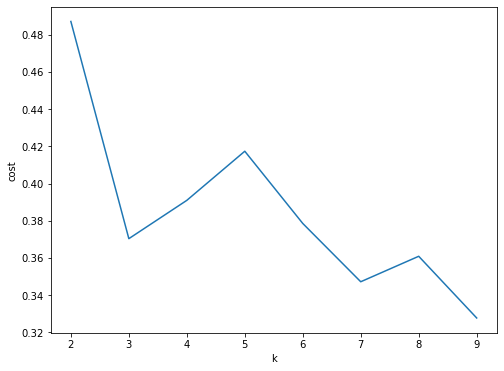

In [78]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [79]:
KMeans_fin=KMeans(featuresCol='bs_sales', k=5)
KMeans_fit=KMeans_fin.fit(t_kmeans)
output_fin=KMeans_fit.transform(t_kmeans)

In [80]:
output_fin.show()

+------------+--------------------+--------------------+----------+
|Product_Code|          norm_sales|            bs_sales|prediction|
+------------+--------------------+--------------------+----------+
|          P1|[0.44,0.5,0.39,0....|[0.34043219942679...|         0|
|          P2|[0.7,0.6,0.3,0.2,...|[0.66101005376612...|         1|
|          P3|[0.36,0.73,0.45,0...|[0.50281915887724...|         0|
|          P4|[0.59,0.35,0.65,0...|[0.47970307520695...|         0|
|          P5|[0.33,0.13,0.67,0...|[0.32804047680577...|         1|
|          P6|[0.27,0.27,0.18,0...|[0.36043200778686...|         1|
|          P7|[0.4,0.8,0.3,0.7,...|[0.61298751797518...|         4|
|          P8|[0.42,0.25,0.58,0...|[0.38234244280979...|         0|
|          P9|[0.73,0.4,0.47,0....|[0.52822478746422...|         1|
|         P10|[0.54,0.42,0.42,0...|[0.49751348068845...|         0|
|         P11|[0.63,0.13,0.63,0...|[0.54214516992202...|         1|
|         P12|[0.33,0.44,0.11,0...|[0.3331481605

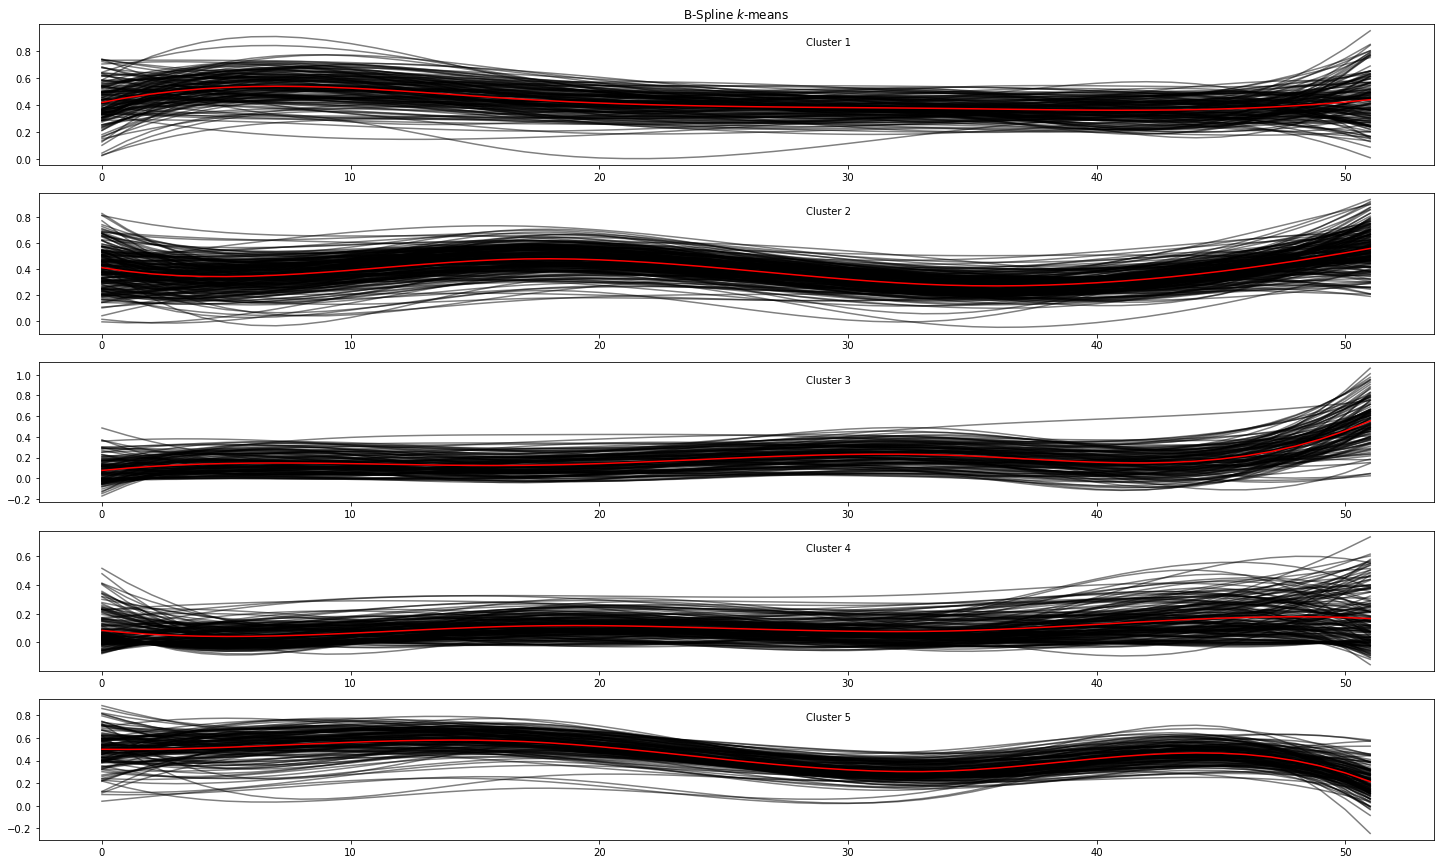

In [122]:
# 각 Cluster 그래프
fig = plt.figure(figsize=(25,15))
for i in range(5):
    plt.subplot(5, 1, i+1)
    for xx in output_fin.filter(output_fin.prediction==i).select('bs_sales').collect():
        plt.plot(np.dot(basis,np.array(xx).T).ravel(), "k-", alpha=.5)
    plt.plot(np.dot(basis, KMeans_fit.clusterCenters()[i]).ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (i + 1),
             transform=plt.gca().transAxes)
    if i == 0:
        plt.title("B-Spline $k$-means")
plt.show()


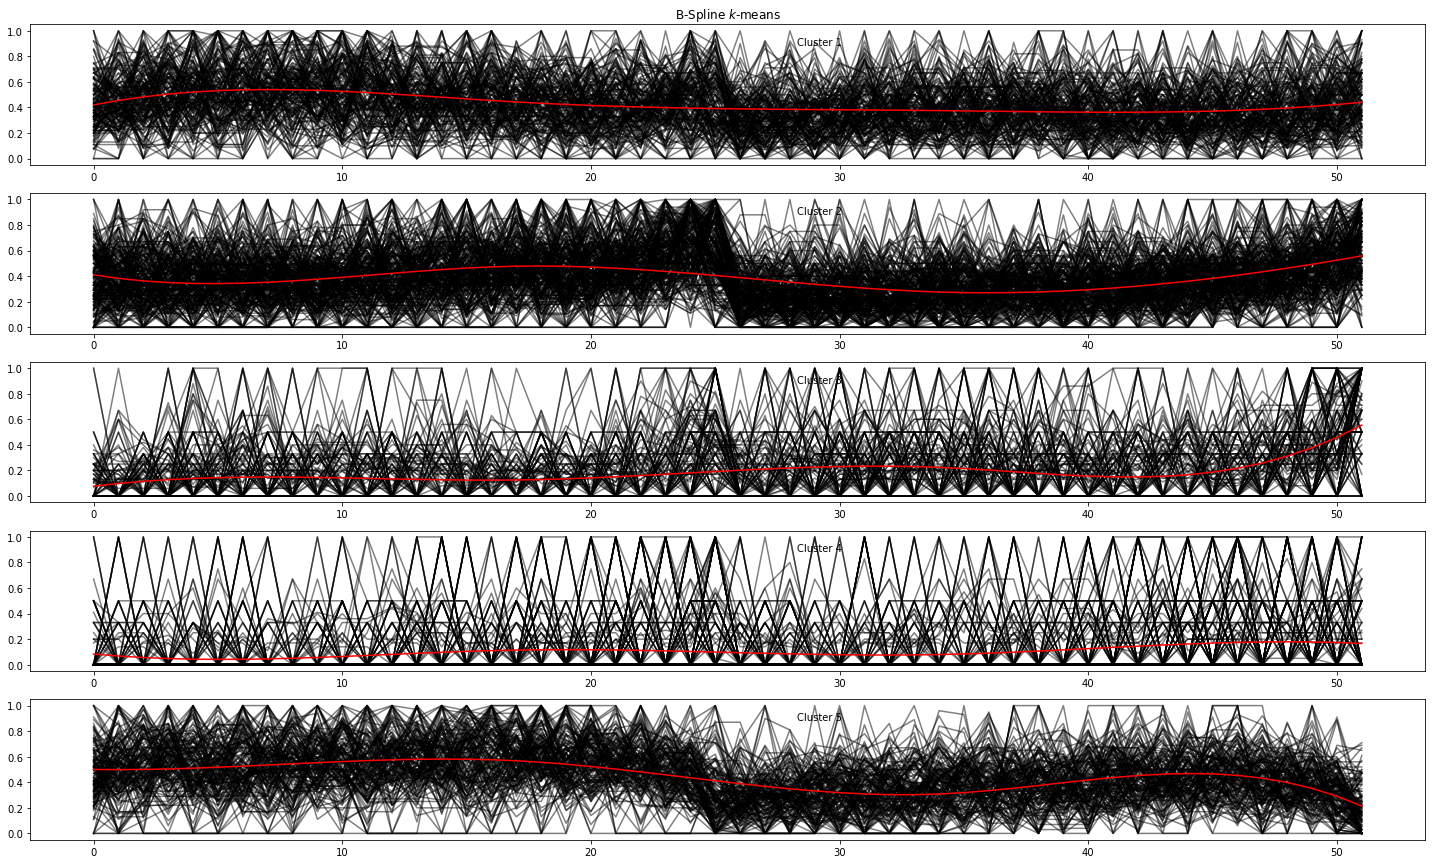

In [123]:
fig = plt.figure(figsize=(25,15))
for i in range(5):
    plt.subplot(5, 1, i+1)
    for xx in output_fin.filter(output_fin.prediction==i).select('norm_sales').collect():
        plt.plot(np.array(xx).ravel(), "k-", alpha=.5)
    plt.plot(np.dot(basis, KMeans_fit.clusterCenters()[i]).ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (i + 1),
             transform=plt.gca().transAxes)
    if i == 0:
        plt.title("B-Spline $k$-means")
plt.show()